In [1]:
from datasets import Dataset, DatasetDict
import pandas as pd
from sentence_transformers import (
    SentenceTransformer,
    SentenceTransformerTrainer,
    SentenceTransformerTrainingArguments,
    SentenceTransformerModelCardData,
)
from sentence_transformers.losses import MultipleNegativesRankingLoss
from sentence_transformers.training_args import BatchSamplers
from sklearn.model_selection import train_test_split

# Load CSV
df = pd.read_csv("500 เมนู label แล้ว - Sheet1.csv")

# Rename columns
df = df.rename(columns={"วัตถุดิบ": "ingredients", "ชื่ออาหาร": "dish"})

# Drop missing values
df = df.dropna(subset=["ingredients", "dish"])

# Split
train_df, temp_df = train_test_split(df, test_size=0.2, random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

# Convert to Hugging Face Dataset
train_dataset = Dataset.from_pandas(train_df[["ingredients", "dish"]])
val_dataset = Dataset.from_pandas(val_df[["ingredients", "dish"]])
test_dataset = Dataset.from_pandas(test_df[["ingredients", "dish"]])

# Model loading
model = SentenceTransformer(
    'paraphrase-multilingual-mpnet-base-v2',
    model_card_data=SentenceTransformerModelCardData(
        language="th",
        license="apache-2.0",
        model_name="Thai Food Ingredients → Dish Prediction",
    )
)

# MultipleNegativesRankingLoss
train_samples = list(zip(train_dataset["ingredients"], train_dataset["dish"]))
val_samples = list(zip(val_dataset["ingredients"], val_dataset["dish"]))
test_samples = list(zip(test_dataset["ingredients"], test_dataset["dish"]))

# Convert samples into DatasetDict with correct format
def convert_to_dict(samples):
    return Dataset.from_dict({
        "anchor": [a for a, b in samples],
        "positive": [b for a, b in samples],
    })

train_dataset = convert_to_dict(train_samples)
val_dataset = convert_to_dict(val_samples)
test_dataset = convert_to_dict(test_samples)

# Create evaluator
from sentence_transformers.evaluation import InformationRetrievalEvaluator

# Build queries and corpus
val_queries = {f'q{i}': val_dataset['anchor'][i] for i in range(len(val_dataset))}
val_corpus = {f'd{i}': val_dataset['positive'][i] for i in range(len(val_dataset))}
val_relevant_docs = {f'q{i}': {f'd{i}'} for i in range(len(val_dataset))}

evaluator = InformationRetrievalEvaluator(
    queries=val_queries,
    corpus=val_corpus,
    relevant_docs=val_relevant_docs,
    name='thai-food-eval',
    show_progress_bar=True,
    precision_recall_at_k=[1, 3, 5]
)

# loss
loss = MultipleNegativesRankingLoss(model)

args = SentenceTransformerTrainingArguments(
    output_dir="models/thai-food-mpnet-tuned",
    num_train_epochs=6,
    per_device_train_batch_size=24,
    per_device_eval_batch_size=24,
    learning_rate=5e-6,
    warmup_ratio=0.1,
    fp16=False,
    bf16=False,
    batch_sampler=BatchSamplers.NO_DUPLICATES,
    eval_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=1,
    logging_strategy="steps",
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    run_name="thai-food-retriever-tuned",
)

# trainer
trainer = SentenceTransformerTrainer(
    model=model,
    args=args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    loss=loss,
    evaluator=evaluator
)

# Train
trainer.train()

# Save the final model
model.save_pretrained("models/thai-food-mpnet/final")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Computing widget examples:   0%|          | 0/1 [00:00<?, ?example/s]

wandb: Currently logged in as: chanisorn-siri (chanisorn-siri-bodindecha) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Thai-food-eval Cosine Accuracy@1,Thai-food-eval Cosine Accuracy@3,Thai-food-eval Cosine Accuracy@5,Thai-food-eval Cosine Accuracy@10,Thai-food-eval Cosine Precision@1,Thai-food-eval Cosine Precision@3,Thai-food-eval Cosine Precision@5,Thai-food-eval Cosine Recall@1,Thai-food-eval Cosine Recall@3,Thai-food-eval Cosine Recall@5,Thai-food-eval Cosine Ndcg@10,Thai-food-eval Cosine Mrr@10,Thai-food-eval Cosine Map@100
1,2.839900,1.455844,0.387755,0.714286,0.795918,0.877551,0.387755,0.238095,0.159184,0.387755,0.714286,0.795918,0.638230,0.560601,0.566458
2,1.671500,1.252936,0.469388,0.755102,0.816327,0.877551,0.469388,0.251701,0.163265,0.469388,0.755102,0.816327,0.686675,0.623664,0.629711
3,1.135200,1.158774,0.489796,0.795918,0.836735,0.897959,0.489796,0.265306,0.167347,0.489796,0.795918,0.836735,0.704028,0.640476,0.645586
4,1.072900,1.103526,0.489796,0.795918,0.836735,0.918367,0.489796,0.265306,0.167347,0.489796,0.795918,0.836735,0.709277,0.641723,0.646062


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Corpus Chunks:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Corpus Chunks: 100%|██████████| 1/1 [00:02<00:00,  2.35s/it]


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Corpus Chunks:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Corpus Chunks: 100%|██████████| 1/1 [00:02<00:00,  2.84s/it]


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Corpus Chunks:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Corpus Chunks: 100%|██████████| 1/1 [00:02<00:00,  2.73s/it]


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Corpus Chunks:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Corpus Chunks: 100%|██████████| 1/1 [00:03<00:00,  3.60s/it]


Epoch,Training Loss,Validation Loss,Thai-food-eval Cosine Accuracy@1,Thai-food-eval Cosine Accuracy@3,Thai-food-eval Cosine Accuracy@5,Thai-food-eval Cosine Accuracy@10,Thai-food-eval Cosine Precision@1,Thai-food-eval Cosine Precision@3,Thai-food-eval Cosine Precision@5,Thai-food-eval Cosine Recall@1,Thai-food-eval Cosine Recall@3,Thai-food-eval Cosine Recall@5,Thai-food-eval Cosine Ndcg@10,Thai-food-eval Cosine Mrr@10,Thai-food-eval Cosine Map@100
1,2.839900,1.455844,0.387755,0.714286,0.795918,0.877551,0.387755,0.238095,0.159184,0.387755,0.714286,0.795918,0.638230,0.560601,0.566458
2,1.671500,1.252936,0.469388,0.755102,0.816327,0.877551,0.469388,0.251701,0.163265,0.469388,0.755102,0.816327,0.686675,0.623664,0.629711
3,1.135200,1.158774,0.489796,0.795918,0.836735,0.897959,0.489796,0.265306,0.167347,0.489796,0.795918,0.836735,0.704028,0.640476,0.645586
4,1.072900,1.103526,0.489796,0.795918,0.836735,0.918367,0.489796,0.265306,0.167347,0.489796,0.795918,0.836735,0.709277,0.641723,0.646062
5,1.018400,1.094212,0.530612,0.795918,0.836735,0.918367,0.530612,0.265306,0.167347,0.530612,0.795918,0.836735,0.725013,0.662893,0.667206
6,0.987000,1.064407,0.551020,0.795918,0.857143,0.918367,0.551020,0.265306,0.171429,0.551020,0.795918,0.857143,0.735843,0.677178,0.681746


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Corpus Chunks:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Corpus Chunks: 100%|██████████| 1/1 [00:02<00:00,  2.36s/it]


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Corpus Chunks:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Corpus Chunks: 100%|██████████| 1/1 [00:02<00:00,  2.35s/it]


Accuracy@1: 0.49
Accuracy@3: 0.65


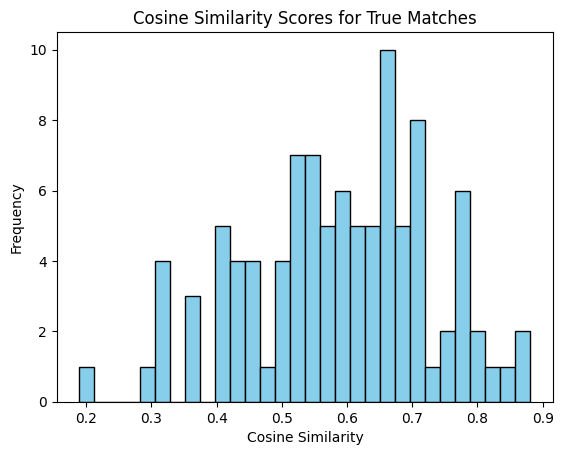

In [2]:
import pandas as pd
from sentence_transformers import SentenceTransformer, util
import matplotlib.pyplot as plt

# Load dataset
df = pd.read_csv("test set noisy 100 edit - Sheet1.csv")

model = SentenceTransformer("models/thai-food-mpnet/final")

# Prepare data
noisy_queries = df["partial_noisy_ingredients"].astype(str).tolist()
clean_references = df["วัตถุดิบ"].astype(str).tolist()

# Encode clean ingredients once
clean_embeddings = model.encode(clean_references, convert_to_tensor=True)

# Variables to store results
correct_top1 = 0
correct_top3 = 0
cosine_scores_true_match = []

total = len(df)

for i in range(total):
    query = noisy_queries[i]
    query_emb = model.encode(query, convert_to_tensor=True)

    # Compute cosine similarity against all clean references
    cos_scores = util.cos_sim(query_emb, clean_embeddings)[0]

    # Get top 3 indices with highest similarity scores
    top_k = 3
    top_k_indices = cos_scores.topk(k=top_k).indices.cpu().numpy()

    # Check if true match (index i) is within top 1 or top 3
    if top_k_indices[0] == i:
        correct_top1 += 1
    if i in top_k_indices:
        correct_top3 += 1

    # Record cosine similarity score of the true match (row i)
    cosine_scores_true_match.append(cos_scores[i].item())

# Calculate accuracy
accuracy_top1 = correct_top1 / total
accuracy_top3 = correct_top3 / total

print(f"Accuracy@1: {accuracy_top1:.2f}")
print(f"Accuracy@3: {accuracy_top3:.2f}")

# Analyze cosine similarity distribution for true matches
plt.hist(cosine_scores_true_match, bins=30, color='skyblue', edgecolor='black')
plt.title("Cosine Similarity Scores for True Matches")
plt.xlabel("Cosine Similarity")
plt.ylabel("Frequency")
plt.show()
